## 1. Импорт бибилиотек и загрузка данных

In [41]:
import pandas as pd

df = pd.read_csv("cookie_cats.csv")
df[:5]
df.groupby("version").count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


## 2. Данные для АБ теста
<p>Данные принадлежат 90 189 игрокам, которые установили игру во время выполнения АБ теста. Переменные:</p>
<ul>
<li><code>userid</code> - уникальный номер-идентификатор каждого игрока</li>
<li><code>version</code> - был ли игрок помещен в контрольную групу
(<code>gate_30</code> - gate at level 30)
(<code>gate_40</code> - gate at level 40).</li>
<li><code>sum_gamerounds</code> - количество раундов игры, сыгранных игроком в течение первых 14 дней после установки</li>
<li><code>retention_1</code> - игрок вернулся и начал играть <strong>через 1 день</strong> после установки?</li>
<li><code>retention_7</code> - игрок вернулся и начал играть <strong>через 7 дней</strong> после установки?</li>
</ul>Когда игрок устанавливал игру, он был случайным образом определен  либо в группу <code>gate_30</code>, либо в <code>gate_40</code>. В качестве проверки адекватности такого распределения необходимо проверить, есть ли примерно одинаковое количество игроков в каждой АБ группе. </p>

In [3]:
# Рассчет количество игкроков в каждой группе

df.groupby("version").count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


## 3. Распределение раундов игры
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png" style="width:200px; float:left"> </p>
<p>Похоже, что в каждой группе примерно одинаковое количество игроков.</p>
<p>Основное внимание в этом анализе будет уделено тому, как распределение игроков (присвоение gate_30 или gate_40) влияет на удержание игроков.</p>
<p>Ради  интереса давайте построим график распределения количества раундов, которые игроки играли в течение своей первой недели игры.</p>

In [6]:
print('Минимальное значение раундов:', min(df["sum_gamerounds"]))
print('максимальное значение раундов:', max(df["sum_gamerounds"]))

Минимальное значение раундов: 0
максимальное значение раундов: 49854


Text(0, 0.5, 'Количество игроков')

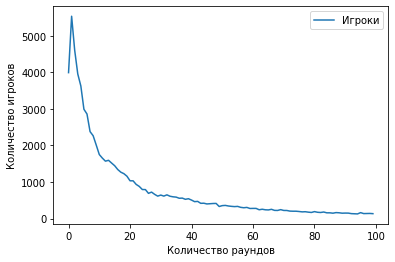

In [12]:
%matplotlib inline
# Рассчитываем кол-во игроков для каждого раунда игры
plot_df = df.groupby("sum_gamerounds").count().reset_index()

# Строим распределение игроков, которые играли от 0 до 100 раундов
ax = plot_df.head(100).plot("sum_gamerounds", "userid", label = 'Игроки')
ax.set_xlabel("Количество раундов")
ax.set_ylabel("Количество игроков")

## 4. Однодневное удержание (1-day retention)
<p>В приведенном выше рисунке мы видим, что некоторые игроки устанавливают игру, но затем либо перестают играть вовсе (0 игровых раундов), либо играют пару игровых раундов в первую неделю, а остальные по-настоящему подсаживаются!</p>
<p>Мы хотим, чтобы игрокам понравилась игра и они подсели на нее. Распространенной метрикой в индустрии видеоигр для определения того, насколько увлекательна игра является <em>1-дневное удержание</em>: Процент игроков, которые возвращаются в игру <em>через один день</em> после того, как они установили ее. Чем выше 1-дневное удержание, тем легче удержать игроков и построить большую базу игроков.</p>
<p>Для давайте рассмотрим, что такое 1-дневное удержание в целом.</p>

In [31]:
# Процент игроков, которые вернулись через день после установки
print('Процент игроков, которые вернулись через день после установки {:.2%}'.\
      format(sum(df["retention_1"])/ len(df)))

Процент игроков, которые вернулись через день после установки 44.52%


## 5. Однодневное удержание по АБ группам
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/belle_cookie.png" style="width:200px; float:right"> </p>
<p>Таким образом, чуть меньше половины игроков возвращаются через день после установки игры. Теперь, когда у нас ориентир для сравнения, давайте посмотрим, как 1-дневное удержание отличается между двумя группами AБ.</p>

In [33]:
# Рассчет однодневного удержания для каждой группы
round(df.groupby("version").agg("mean")["retention_1"] * 100, 2)

version
gate_30    44.82
gate_40    44.23
Name: retention_1, dtype: float64

## 6. Можем ли мы доверять этой разнице?
<p>По-видимому, наблюдалось незначительное снижение метрики для группы gate_40 (44,2%) по сравнению с группой gate_30 (44,8%). Это небольшое изменение, но даже небольшие изменения в удержании могут иметь большое влияние. Можем ли мы доверять выводу, что выход на уровне 40 будет хуже в будущем?</p>
<p>Есть несколько способов, которыми мы можем получить уверенность в этих числах удержания. Здесь мы будем использовать bootstrapping: мы будем многократно повторять выборку нашего набора данных (с заменой) и вычислять 1-дневное удержание для этих выборок. Вариация в 1-дневном удержании даст нам представление о том, насколько неопределенны цифры удержания.</p>

In [34]:
df.sample(frac=1, replace=True)
df[:3]

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


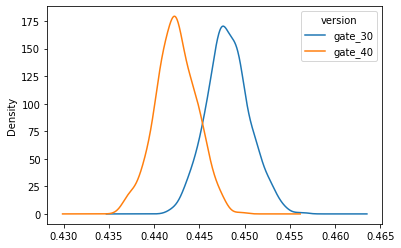

In [35]:
# Создание списка с bootstrapped mean для каждой группы

iterations = 500
boot_1d = []
for i in range(iterations):
    boot_mean = (
        df.sample(frac=1, replace=True).groupby("version").agg("mean")["retention_1"]
    )
    boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)

# рисуем Kernel Density Estimate plot
boot_1d.plot.kde()

## 7. Увеличение масштаба разницы
<p>Эти два распределения выше представляют собой бутстрэпную неопределенность относительно того, что может лежать в основе 1-дневного удержания для двух AB-групп. Просто наблюдая за этим сюжетом, мы можем видеть, что, кажется, есть некоторые доказательства различия, хотя и небольшие. Давайте увеличим разницу в 1-дневном удержании</p>
<p>(<em>Обратите внимание, что в этой записной книжке мы ограничили число загрузочных репликаций до 500, чтобы ускорить вычисления. В "производстве" мы, скорее всего, увеличим это число (к примеру до 10 000.</em>)</p>

Text(0.5, 0, 'разница между АБ группами (%) - multiple bootstrapped samples')

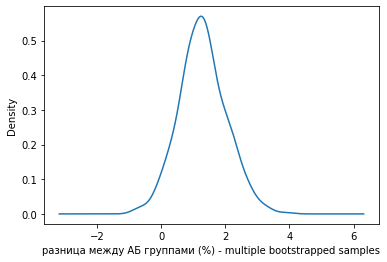

In [42]:
# Добавление столбца с процентной разницей метрики между двумя группами
boot_1d["diff"] = (boot_1d["gate_30"] - boot_1d["gate_40"]) * 100 / boot_1d["gate_40"]

# Рисуем для рассчитанной разницы распределение
ax = boot_1d["diff"].plot.kde()
ax.set_xlabel("разница между АБ группами (%) - multiple bootstrapped samples")

## 8. Вероятность разницы
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/ziggy_smiling.png" style="width:200px; float:left"> </p>
<p>Из этой диаграммы мы можем видеть, что наиболее вероятная разница в % составляет около 1% - 2%, и что большая часть распределения выше 0%, в пользу группы gate_30. Но какова вероятность того, что разница будет выше 0%? Давайте и это рассчитаем.</p>

In [38]:
# Вероятность того, что однодневное удержание у gate_30 больше
prob = sum(boot_1d["diff"] > 0) / len(boot_1d["diff"])
print(prob * 100, "%")

96.6 %


## 9. 7-дневное удержание по группам
<p>Анализ начальной загрузки говорит нам, что существует высокая вероятность того, что 1-дневное удержание будет лучше, когда ворота находятся на уровне 30.</p>
<p>Однако, поскольку игроки играют в эту игру только один день, вполне вероятно, что большинство игроков еще не достигли 30-го уровня. То есть многие игроки так и не дойдут до ворот, даже если они будут на 30 уровне.</p>
<p>Но после игры в течение недели больше игроков может дойти до 40-го уровня, и поэтому имеет смысл также посмотреть на 7-дневное удержание. То есть: какой процент людей, установивших игру, также появился через неделю, чтобы снова поиграть.</p>

In [39]:
round(df.groupby("version").agg("mean")["retention_7"] * 100, 2)

version
gate_30    19.02
gate_40    18.20
Name: retention_7, dtype: float64

<p>Как и в случае с 1-дневной задержкой, мы видим, что 7-дневная задержка немного ниже (18,2%), когда ворота находятся на уровне 40, чем когда ворота находятся на уровне 30 (19,0%).</p>
<p>Мы также видим, что общее 7-дневное удержание ниже, чем общее 1-дневное удержание; меньше людей играют в игру через неделю после установки, чем через день после установки.</p>
<p>Но, как и прежде, давайте воспользуемся bootstrap-анализом, чтобы выяснить, насколько можно доверять различиям между АБ-группами.</p>

100.0 %


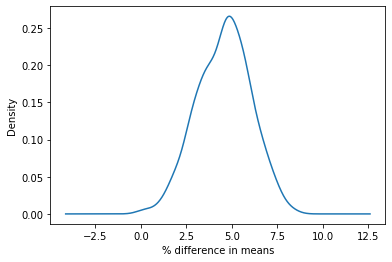

In [40]:
# Создание списка с bootstrapped mean для каждой группы
boot_7d = []
for i in range(500):
    boot_mean = (
        df.sample(frac=1, replace=True).groupby("version").agg("mean")["retention_7"]
    )
    boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)

# Добавление столбца с процентной разницей метрики между двумя группами
boot_7d["diff"] = (boot_7d["gate_30"] - boot_7d["gate_40"]) * 100 / boot_7d["gate_40"]

# Рисуем для рассчитанной разницы распределение
ax = boot_7d["diff"].plot.kde()
ax.set_xlabel("% difference in means")

# Вероятность того, что 7-дневное удержание у gate_30 больше
prob = (boot_7d["diff"] > 0).mean()
print(prob * 100, "%")

## 11.  Вывод
<p>Результат бутстрапного анализа говорит нам о том, что 7-дневное удержание выше, когда ворота находятся на уровне 30, чем на уровне 40. Вывод таков: если мы хотим сохранить высокое удержание — как 1-дневное, так и 7-дневное — мы должны <strong>не</strong> перемещать ворота с уровня 30 на уровень 40. Есть, конечно, и другие показатели, которые мы могли бы посмотреть, например, количество сыгранных раундов игры или количество внутриигровых покупок, сделанных двумя АБ-группами. Но "удержание" это один из самых важных показателей. Если мы не сохраним нашу базу игроков, не имеет значения, сколько денег они тратят в игре.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_yellow.png" style="width:100px; float:center"> </p>
<p>Итак, почему удержание выше, когда ворота расположены раньше? Можно было ожидать и обратного: чем позже возникнет препятствие, тем дольше люди будут играть. Но это не то, что говорят нам данные. Теория гедонической адаптации может дать этому одно объяснение. Если кратко, гедоническая адаптация - это тенденция людей получать все меньше и меньше удовольствия от веселой деятельности с течением времени, если эта деятельность осуществляется непрерывно. Заставляя игроков делать перерыв, когда они достигают ворот, их удовольствие от игры продлевается. Но когда ворота перемещаются на 40-й уровень, игроки с большей вероятностью выйдут из игры, потому что им просто стало скучно.</p>